# Libreta AI Cup 2025
Esta libreta está siendo desarrolada por:
1. p
2. p
3. 

Y su asesor:
1. Braulio Sánchez

Aquí describan el proyecto.

In [31]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn.functional as F
from PIL import Image
import glob
from torch.utils.data import Dataset, DataLoader
from typing import Any, Tuple, Callable

In [32]:
type Path = Any
type Model = Any
type Images = Any
type Embeddings = Any

- Obtener todas las imagenes dado un folder

In [33]:
def get_all_images(path : Path) -> Images:
    return glob.glob(os.path.join(path, "*.jpg")) + \
           glob.glob(os.path.join(path, "*.png")) + \
           glob.glob(os.path.join(path, "*.jpeg")) + \
           glob.glob(os.path.join(path, "*.bmp"))

# **Clases del modelo**
### ***TripletNet***:
    - Se usa un modelo pre-entrenado para asi poder realizar un entrenamiento mucho más óptimo
### ***TripletLoss***:
    - Se usa para poder obtener la pérdida tomando en cuenta la siguiente función: 
$$Loss=max(d(A,P)−d(A,N)+margin,0)$$

### ***TripletDataset***:
    - Esta clase es donde guardaremos nuestro dataset, además se implementan funciones para poder obtener su tamaño, y poder obtener las 3 imágenes

In [34]:
# Modelo base (ResNet18) con capa de embeddings
class TripletNet(nn.Module):
    def __init__(self, pretrained=True):
        super(TripletNet, self).__init__()
        self.base_model = models.resnet18(pretrained=pretrained)
        self.base_model.fc = nn.Linear(512, 128)  # Reducimos a 128 dimensiones

    def forward(self, x : Images) -> Embeddings:
        return self.base_model(x)

In [35]:
class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor : Images, positive : Images, negative : Images) -> Embeddings:
        # Calculamos las distancias entre los embeddings
        positive_distance = F.pairwise_distance(anchor, positive, p=2)
        negative_distance = F.pairwise_distance(anchor, negative, p=2)
        
        # Triplet loss
        loss = torch.clamp(positive_distance - negative_distance + self.margin, min=0.0)
        return loss.mean()


In [36]:
class TripletDataset(Dataset):
    def __init__(self, folder_defective : Path, folder_non_defective : Path, transform=None):
        self.folder_defective = folder_defective
        self.folder_non_defective = folder_non_defective
        self.transform = transform
        
        # Obtener las imágenes de cada clase
        self.defective_images = get_all_images(folder_defective)
        
        self.non_defective_images = get_all_images(folder_non_defective)
        
    def __len__(self):
        return len(self.defective_images) + len(self.non_defective_images)
        
    def __getitem__(self, idx):
        # Obtener las imágenes de cada clase
        anchor_img = Image.open(self.defective_images[idx % len(self.defective_images)]).convert("RGB")
        positive_img = Image.open(self.defective_images[(idx + 1) % len(self.defective_images)]).convert("RGB")
        negative_img = Image.open(self.non_defective_images[idx % len(self.non_defective_images)]).convert("RGB")
        
        if self.transform:
            anchor_img = self.transform(anchor_img)
            positive_img = self.transform(positive_img)
            negative_img = self.transform(negative_img)
        
        return anchor_img, positive_img, negative_img


# Data Augmentation
- Se utiliza para realizar el data augmentation. Donde se puede modificar las transformaciones para poder hacer mejores imagenes con mejor calidad y asi obtener unos mejores resultados al entrenar al modelo.

In [49]:
def get_augmentations():
    """
    Devuelve una secuencia de transformaciones para Data Augmentation asegurando que la imagen siga en escala de grises.
    """
    return transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(10, fill=0),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.RandomResizedCrop(224, scale=(0.9, 1.0)),
        transforms.RandomAffine(degrees=5, shear=2, fill=0),
        transforms.ToTensor()
    ])

def augment_and_save_image(image_path : Path, output_folder : Path, image_name : Images):
    """
    Aplica data augmentation a una imagen y guarda las imágenes augmentadas en una carpeta.
    """
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    # Cargar la imagen
    image = Image.open(image_path).convert('RGB')
    
    # Obtener las transformaciones
    augmentation = get_augmentations()

    # Crear varias imágenes aumentadas y guardarlas
    for i in range(5):  # Generar 5 versiones aumentadas de cada imagen
        augmented_image = augmentation(image)
        
        # Convertir el tensor de nuevo a imagen
        augmented_image = transforms.ToPILImage()(augmented_image)
        
        # Guardar la imagen en el folder de salida
        augmented_image.save(os.path.join(output_folder, f"{image_name}_aug_{i}.jpg"))

def augment_dataset(input_folder : Path, output_folder : Path):
    """
    Aplica data augmentation a todas las imágenes de un directorio y las guarda en el directorio de salida.
    """
    image_paths = get_all_images(input_folder)  # Obtener todas las imágenes del folder
    
    for image_path in image_paths:
        image_name = os.path.splitext(os.path.basename(image_path))[0]  # Obtener nombre base de la imagen
        augment_and_save_image(image_path, output_folder, image_name)

In [38]:
input_folder = "dataset/Defective"  # Ruta a las imágenes originales
output_folder = "dataset_augmented/Defective"
augment_dataset(input_folder, output_folder)

input_folder = "dataset/Non-defective"  # Ruta a las imágenes originales
output_folder = "dataset_augmented/Non-Defective"
augment_dataset(input_folder, output_folder)

# Configuracón e inicialización del modelo
- Si contamos con gráfica nvidia se usará para entrenar al modelo, de lo contrario usará tu cpu.
- Se inicializa el modelo **Triplet Loss**
- Además se agregan unas optimizaciones (Ojo: Esto se puede modificar para poder obtener un mejor resultado de entramiento)

In [39]:
# Configuración del dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [57]:
# Inicializar el modelo
model = TripletNet().to(device)

# Inicializar Triplet Loss
triplet_loss = TripletLoss(margin=1.0).to(device)

# Optimizer
criterion = nn.TripletMarginLoss(margin=1.0)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)


# Carga un modelo entrenado
- Si ya cuentas con un modelo entrenado puedes cargarlo directamente para no tener que volver a entrar el modelo.

In [ ]:
model = TripletNet(False).to(device)
model.load_state_dict(torch.load("model/model.pth", map_location=device))
model.eval()

# Transfomarciones y carga de los datos
- Obtenemos todas las imgenes desde nuestro dataset

In [51]:
# Transformaciones para las imágenes
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

defective_dir = "dataset_augmented/Defective/"
non_defective_dir = "dataset_augmented/Non-Defective/"

# Cargar los datos
train_dataset = TripletDataset(defective_dir, non_defective_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)


# Entrenamiento del modelo
- Aquí hay que tener cuidado al momento de entrenar un modelo, ya que puede llegar a ser muy pesado dependiendo de que modelo estemos entrenando y de nuestro dataset. Por ende debemos tener cuidado con las epocas que realizamos. Al final se muestra la grafica de la perdida (La cual se puede observar extraña debido a que nuestro dataset no es el mejor por lo que puede haber cambios en la péridida y mal resultado de entrenamiento, entre mas cerca a 0 mejor)

Epoch [1/20], Loss: 0.8016
Epoch [2/20], Loss: 0.2527
Epoch [3/20], Loss: 0.1941
Epoch [4/20], Loss: 0.0080
Epoch [5/20], Loss: 0.0298
Epoch [6/20], Loss: 0.0050
Epoch [7/20], Loss: 0.0000
Epoch [8/20], Loss: 0.1518
Epoch [9/20], Loss: 0.0966
Epoch [10/20], Loss: 0.0533
Epoch [11/20], Loss: 0.4033
Epoch [12/20], Loss: 0.2098
Early stopping at epoch 12


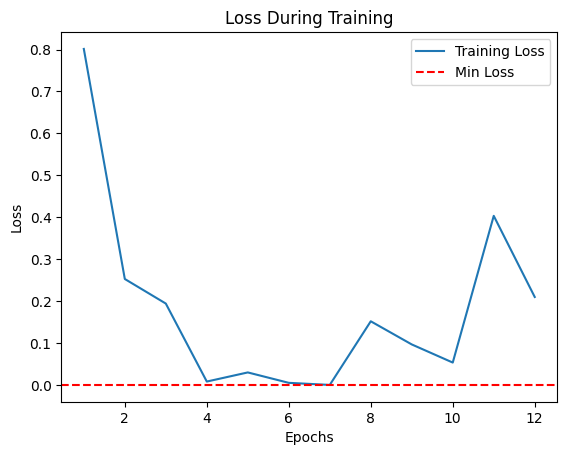

In [59]:
import matplotlib.pyplot as plt

losses = []
num_epochs = 20
patience = 5
best_loss = float('inf')
epochs_without_improvement = 0

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.1)

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    
    for batch_idx, (anchor, positive, negative) in enumerate(train_loader):
        anchor = anchor.to(device)
        positive = positive.to(device)
        negative = negative.to(device)
        
        optimizer.zero_grad()

        anchor_output = model(anchor)
        positive_output = model(positive)
        negative_output = model(negative)

        loss = triplet_loss(anchor_output, positive_output, negative_output)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    
    epoch_loss = total_loss / len(train_loader)
    losses.append(epoch_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.10f}")

    # Early Stopping
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        epochs_without_improvement = 0
        # Guardar el mejor modelo
        torch.save(model.state_dict(), "model/model.pth")
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    scheduler.step(epoch_loss)

# Graficar la pérdida
plt.plot(range(1, len(losses) + 1), losses, label='Training Loss')
plt.axhline(y=min(losses), color='r', linestyle='--', label='Min Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss During Training')
plt.legend()
plt.show()

# Segunda forma de entrenamiento
- Al igual que en la celda anterior, aqui se hace una optimizacón diferente, pueden ir probrando con ambas y viendo caul es la mejor. Investiguen como funcionan y cual les conviene.

In [ ]:
# Usar un scheduler para el optimizador
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# En cada época, actualizar el scheduler
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    
    for batch_idx, (anchor, positive, negative) in enumerate(train_loader):
        anchor = anchor.to(device)
        positive = positive.to(device)
        negative = negative.to(device)
        
        optimizer.zero_grad()

        anchor_output = model(anchor)
        positive_output = model(positive)
        negative_output = model(negative)

        loss = triplet_loss(anchor_output, positive_output, negative_output)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # Actualizar el scheduler
    scheduler.step()

    epoch_loss = total_loss / len(train_loader)
    losses.append(epoch_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")


# Guardar el modelo entrenado
- Vamos a guardar el modelo para no tener que estar entrenandolo cada vez que iniciamos nuestra libreta. Por lo cual podemos usarlo en otros programas.

In [ ]:
# Guardar el modelo entrenado
torch.save(model.state_dict(), "model/triplet_model.pth")

# Pruebas y Observaciones
- Aqui se hacen las pruebas de nuestro modelo con nuestras imagenes de testeo. Mucho cuidado, no usar imagenes de testeo para entrenar y viceversa. Ya que eso perjudica nuestro entrenamieto, a este tipo de entrenamiento se le llama Aprendizaje Supervisado ya que nosotros tenemos nuestro train dataset y nuestro test dataset.
- Para poder ver que tipo es una imagen es en base al promedio (no es la unica forma, si encuentran una mejor forma para decir que una imagen es de un tipo pueden probrala)

In [60]:
# Obtener los embeddings promedio para las imágenes defectuosas y no defectuosas
def get_average_embedding(image_paths : Path):
    embeddings = []
    for image_path in image_paths:
        img = Image.open(image_path).convert("RGB")
        img = transform(img).unsqueeze(0).to(device)
        
        with torch.no_grad():
            embedding = model(img)
        embeddings.append(embedding)
    
    # Calcular el promedio de los embeddings
    return torch.mean(torch.stack(embeddings), dim=0)

In [66]:
# Función para obtener el embedding de una imagen
def get_embedding(image_path : Path):
    img = Image.open(image_path).convert("RGB")
    img = transform(img).unsqueeze(0).to(device)
    
    with torch.no_grad():
        embedding = model(img)
    return embedding

# Función para clasificar una imagen nueva
def classify_image(image_path):
    test_embedding = get_embedding(image_path)
    # Obtener imágenes de cada clase
    defective_images = get_all_images("dataset/Defective")
    non_defective_images = get_all_images("dataset/Non-defective")
    
    defective_avg = get_average_embedding(defective_images)
    non_defective_avg = get_average_embedding(non_defective_images)

    dist_defective = F.pairwise_distance(test_embedding, defective_avg).item()
    dist_non_defective = F.pairwise_distance(test_embedding, non_defective_avg).item()

    # print(f"Distancia a Defective: {dist_defective:.4f}")
    # print(f"Distancia a Non-Defective: {dist_non_defective:.4f}")

    if dist_defective < dist_non_defective:
        return ("Defective", dist_defective)
    else:
        return ("Non-Defective", dist_non_defective)


In [67]:
defective = 0
non_defective = 0

test_imgs = get_all_images("test")

for img in test_imgs:
    result, d = classify_image(img)
    if result == "Defective":
        defective += 1
    else:
        non_defective += 1
    print(f"La imagen {img} es clasificada como: {result} d: {d}")
print(f"Se clasificaron como defective: {defective} de {len(test_imgs)}")
print(f"Se clasificaron como non-defective: {non_defective} de {len(test_imgs)}")

La imagen test/testnondefective.jpg es clasificada como: Non-Defective d: 0.11085343360900879
La imagen test/testdefective.jpg es clasificada como: Defective d: 0.09722262620925903
Se clasificaron como defective: 1 de 2
Se clasificaron como non-defective: 1 de 2
